# Réduction de variance et calcul de sensibilités

Sur on problème de modélisation classique en assurance, on illustre l'importance de l'erreur relative puis deux techniques de réduction de variance: 

- méthode par préconditionnement, 
- échantillonage d'importance (important pour les événements rares).

Dans une deuxième partie on s'intéresse aux sensibilités et comment implémenter efficacement la méthode des différences finies avec la méthode de Monte Carlo. 

In [1]:
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme() 
from numpy.random import default_rng
rng = default_rng()

## Charge sinistre et loi Poisson-composée

On définit la _charge sinistre totale_ (sur une période $T$) par la variable aléatoire positive
\begin{equation*}
    S = \sum_{i = 1}^N X_i
\end{equation*}
où $N$ est une variable aléatoire à valeurs dans $\mathbf{N}$ représentant le nombre de sinistres sur la période $T$, et pour $i \ge 1$, $X_i$ est une variable aléatoire à valeurs dans $\mathbf{R}_+$ représentant le coût du i-ème sinistre, avec la convention selon laquelle la somme est nulle si $N = 0$. Les $(X_i)_{i \ge 1}$ sont supposées indépendantes et identiquement distribuées, et indépendantes de $N$ (indépendance fréquences - coûts).

Une modélisation classique est de considérer 

- $N$ de loi de Poisson de paramètre $\lambda > 0$, 
- $X_1$ de loi log-normale de paramètres $\mu > 0$, $\sigma^2 > 0$, c'est à dire $X_1 = \exp(G_1)$ avec $G_1 \sim \mathcal{N}(\mu, \sigma^2)$. 

Le but est d'estimer la **probabilité de dépassement** c'est à dire calculer la probabilité que la charge sinistre totale dépasse un seuil $K$:
\begin{equation*}
    p = \mathbf{P}\bigl[S > K\bigr] \quad \text{pour $K$ grand}
\end{equation*}

Dans la suite on prend $\lambda = 10$, $\mu = 0.1$ et $\sigma = 0.3$ et on considère plusieurs valeurs du seuil $K$.

### Question: simulation de la charge sinistre totale 

Ecrire une fonction `simu_S(size, mu, sigma, lambd)` qui renvoie un échantillon de taille `size` de réalisations indépendantes de $S$.

In [2]:
def simu_S(size, mu, sigma, lambd): 
    sample_N = rng.poisson(size=size, lam=lambd)
    sample_S = np.empty(size)
    for k, Nk in enumerate(sample_N):
        sample_S[k] = np.sum(rng.lognormal(size=Nk, mean=mu, sigma = sigma))
    return sample_S

In [3]:
lambd, mu, sigma = 10, 0.1, 0.3
simu_S(10, mu, sigma, lambd)

array([14.4466024 , 13.13255371, 12.24657664, 20.59847054,  9.67230721,
        8.59942146, 11.15897782,  8.77575021, 10.07199458, 10.43166136])

### Question: représentation graphique 

Représenter l'histogramme d'un échantillon de $100\,000$ réalisations de $S$ et du seuil $K = 20$ par une ligne verticale rouge.

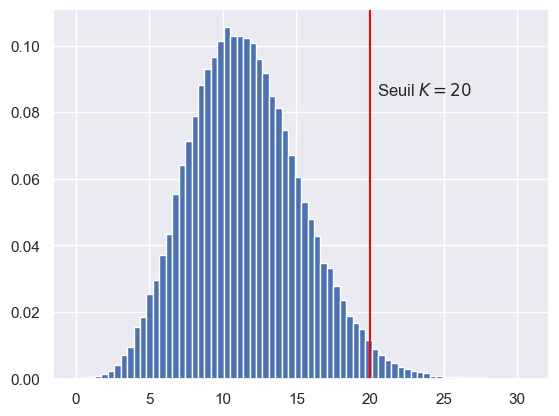

In [4]:
sample_S = simu_S(int(1e5), mu, sigma, lambd)
K = 20

fig, ax = plt.subplots()
ax.hist(sample_S, bins=70, density=True)
ax.axvline(K, color='red')
ax.text(K+.5, 0.085, fr'Seuil $K={K}$', size=12)
plt.show()

## Estimateur Monte Carlo et erreur relative 

Soit $p_n = \displaystyle \frac{1}{n} \sum_{j=1}^n \mathbf{1}_{S^{(j)} > K}$ l'estimateur Monte Carlo de $p= \mathbf{P}\bigl[S > K\bigr]$ où $(S^{(j)})_{j=1,\dots,n}$ est une suite _i.i.d._ de même loi que $S$.

On rappelle que:

- l'**erreur absolue** de l'estimateur Monte Carlo $p_n$ est définie par $|p_n - p|$ et qu'avec probabilité 0.95 cette erreur est bornée par $e_n = 1.96 \frac{\sigma_n}{\sqrt{n}}$ avec $\sigma_n^2 = p_n - p_n^2$,
- l'**erreur relative** de l'estimateur Monte Carlo est définie par $\frac{|p_n - p|}{p}$ que l'on majore avec probabilité 0.95 par $\frac{e_n}{p_n}$.

### Question: erreur relative 

Ecrire une fonction `relative_error` qui à partir d'un échantillon de $S$ (de taille $n$) et d'une valeur de seuil $K$ renvoie la probabilité $p_n$ et l'erreur relative (plus exactement la borne $\frac{e_n}{p_n}$ à 95%). 

Tracer l'erreur relative d'un échantillon de taille $100\,000$ en fonction de $K$ pour $K$ allant de 20 à 30. Comment interpréter cette courbe? 

In [5]:
def relative_error(sample, K):
    p_n = np.mean(sample > K)
    v_n = p_n - p_n**2
    e_n = 1.96 * np.sqrt(v_n / sample.size)
    return p_n, e_n / p_n

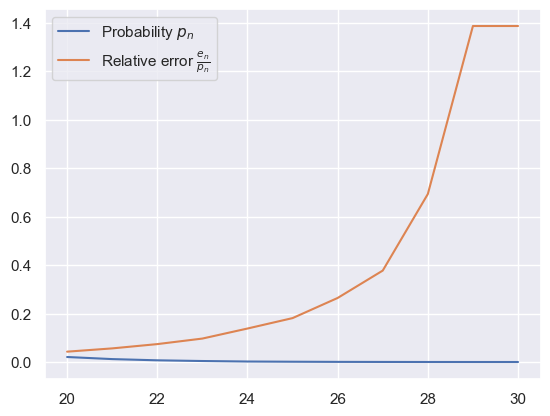

In [6]:
Ks = np.arange(20, 31)
errors = np.array([relative_error(sample_S, K) for K in Ks])
fig, ax = plt.subplots()
ax.plot(Ks, errors)
ax.legend((r'Probability $p_n$',r'Relative error $\frac{e_n}{p_n}$'))
plt.show()

### Question: Monte Carlo à précision fixée

Mettre en oeuvre un estimateur de Monte Carlo qui s'arrête dès que l'erreur relative est de 5%. On pourra par exemple introduire la variable aléatoire
\begin{equation*}
    \tau^{(m)} = \inf \bigl\{n \ge 1, e_{n m} \le 0.05 p_{n m} \bigr\},
\end{equation*}
qui dépend d'un paramètre $m$ fixé, par exemple $m = 10\,000$, et renvoyer $p_{\tau^{(m)}}$ ainsi que l'erreur relative et la taille de l'estimateur associé. 
Le paramètre $m$ permet de recalculer l'estimateur et l'erreur uniquement toutes les $m$ itérations et donc de réduire la complexité par rapport au choix naïf $m = 1$. On appelle ce paramètre $m$ la taille du _batch_ (size batch). 
Le nombre d'itérations (la taille de l'échantillon) dans la méthode de Monte Carlo pour un $\tau^{(m)}$ donné est donc $\tau^{(m)} \times m$. 

Définir la fonction qui code cet estimateur Monte Carlo:
```
monte_carlo_relative(mu, sigma, lambd, K, size_batch = 10000, error = 0.05)
```

In [7]:
def monte_carlo_relative(mu, sigma, lambd, K, size_batch = 10000, error = 0.05):
    sample_S = simu_S(size_batch, mu, sigma, lambd)
    while True:
        p_n, er_n = relative_error(sample_S, K)
        if er_n < error: 
            return p_n, er_n, len(sample_S)
        else:
            new_sample = simu_S(size_batch, mu, sigma, lambd)
            sample_S = np.append(sample_S, new_sample)

### Question: complexité en fonction de $K$

Reproduire un tableau de résultat similaire au tableau suivant obtenu avec cet estimateur de Monte Carlo adaptatif jusqu'à l'itération $\tau^{(m)} \times m$ pour une erreur relative de 10% et pour différentes valeurs de $K = 20,\dots,25$.  

Tracer le nombre d'itérations nécessaires en fonction de $K$.

In [8]:
import pandas as pd
df = pd.read_pickle("data/iterations_df.pkl")
df

Probabilité $p_n$  Erreur relative  Itérations
20           0.021600         0.093277       20000
21           0.013100         0.098219       30000
22           0.007820         0.098733       50000
23           0.003910         0.098927      100000
24           0.002259         0.099908      170000
25           0.001258         0.099186      310000

In [9]:
Ks = np.arange(20, 26)
result = np.array([monte_carlo_relative(mu, sigma, lambd, K, error = 0.1) for K in Ks])

In [10]:
import pandas as pd
res_df = pd.DataFrame(result, 
                      columns=("Probabilité $p_n$", "Erreur relative", "Itérations"), 
                      index = Ks)
res_df = res_df.astype({'Itérations': 'int'})
res_df
#res_df.to_pickle("data/iterations_df.pkl")  

Probabilité $p_n$  Erreur relative  Itérations
20           0.021800         0.092838       20000
21           0.012775         0.086150       40000
22           0.007700         0.099506       50000
23           0.004378         0.098527       90000
24           0.002156         0.099397      180000
25           0.001129         0.098563      350000

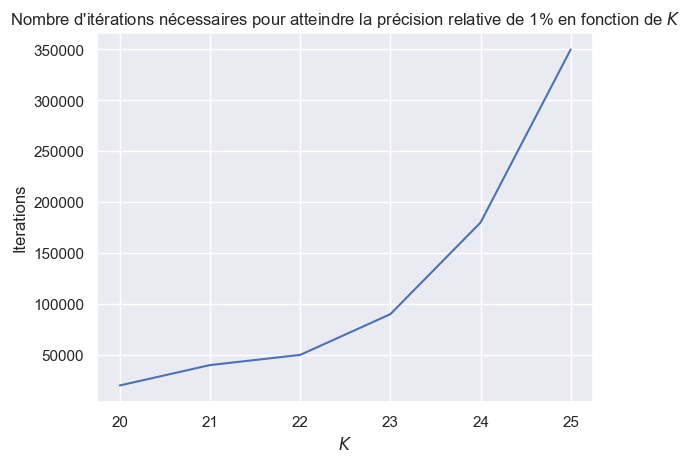

In [11]:
fig, ax = plt.subplots()
ax.plot(Ks, res_df['Itérations'], label="Iterations")
ax.set_xlabel(r"$K$")
ax.set_ylabel(r"Iterations")
ax.set_title(r"Nombre d'itérations nécessaires pour atteindre la précision relative de 1% en fonction de $K$")
plt.show()

## Réduction de variance par préconditionnement 

Pour réduire la variance on teste d'abord l'idée présentée dans l'exercice 1 du TD3, c'est à dire qu'on considère la variable aléatoire 
\begin{equation*}
    M = \inf \bigl\{ r \ge 1, \sum_{i=1}^r X_i > K \bigr\}
\end{equation*}
et la représentation suivante
\begin{equation*}
    p = \mathbf{E} \bigl[\phi(M) \bigr] \quad \text{avec} \quad \phi(m) = \mathbf{P} \bigl[ N \ge m \bigr]
\end{equation*}


### Question: simulation de $M$ 

Ecrire une fonction `simu_M` similaire à la fonction `simu_S` avec l'argument $K$ supplémentaire qui renvoie un échantillon _i.i.d._ de même loi que $M$. 

In [12]:
def simu_M(size, mu, sigma, lambd, K): 
    def one_M():
        sum_Xi = rng.lognormal(size=1, mean=mu, sigma = sigma)
        r = 1
        while sum_Xi <= K:
            sum_Xi += rng.lognormal(size=1, mean=mu, sigma = sigma)
            r += 1
        return r
    sample_M = np.array([ one_M() for _ in range(size) ]) 
    return sample_M 

# la fonction précédente est correcte mais trop lente car il y a de très 
# nombreux appels successifs au générateur de taille size=1 ce qui est 
# à éviter. voici une version plus optimisée 

def simu_M(size, mu, sigma, lambd, K, batch_size=20): 
    def one_M():
        sample_x = np.zeros(1)
        while True:
            sample_x = np.append(sample_x, 
                                 rng.lognormal(size=batch_size, mean=mu, sigma = sigma))
            r = np.argmax(np.cumsum(sample_x) > K)
            if r > 0: return r
        return r
    sample_M = np.array([ one_M() for _ in range(size) ]) 
    return sample_M

# exercice: faire un code similaire sans "grossir" sample_x avec np.append

### Question: Monte Carlo et ratio de variance 

En utilisant la fonction `monte_carlo` du TP précédent. Calculer le ratio de variance entre l'estimateur $p_n$ et l'estimateur basé sur la représentation $p = \mathbf{E}[\phi(M)]$ où $\phi$ est calculée en utilisant la fonction de survie et la fonction de masse de la loi de Poisson (cf. la documentation de `stats.poisson`). Faire ce calcul pour différentes valeurs de $K$ et $n = 20\,000$

In [13]:
def monte_carlo(sample, proba = 0.95):
    mean = np.mean(sample)
    var = np.var(sample, ddof=1)
    alpha = 1 - proba 
    quantile = stats.norm.ppf(1 - alpha/2)  # fonction quantile 
    ci_size = quantile * np.sqrt(var / sample.size)
    return (mean, var, mean - ci_size, mean + ci_size)

In [72]:
Ks = np.arange(20,30)
sample_S = simu_S(int(1e6), mu, sigma, lambd)
result = [ monte_carlo(sample_S > K) for K in Ks ]
import pandas as pd
res_df = pd.DataFrame(result, 
                      columns=["mean", "var", "lower", "upper"], 
                      index=Ks)
res_df

mean       var     lower     upper
20  0.021368  0.020911  0.021085  0.021651
21  0.012760  0.012597  0.012540  0.012980
22  0.007263  0.007210  0.007097  0.007429
23  0.004040  0.004024  0.003916  0.004164
24  0.002217  0.002212  0.002125  0.002309
25  0.001175  0.001174  0.001108  0.001242
26  0.000583  0.000583  0.000536  0.000630
27  0.000315  0.000315  0.000280  0.000350
28  0.000159  0.000159  0.000134  0.000184
29  0.000083  0.000083  0.000065  0.000101

In [15]:
def phi(m, lambd = 10):
    N = stats.poisson(mu = lambd)
    return N.pmf(m) + N.sf(m) 

In [16]:
result = [] 
for K in Ks:
    sample_M = simu_M(int(2e4), mu, sigma, lambd, K)
    result.append(monte_carlo(phi(sample_M)))
import pandas as pd
res_df_precond = pd.DataFrame(result, 
                      columns=["mean", "var", "lower", "upper"], 
                      index=Ks)
res_df_precond

mean       var     lower     upper
20  0.021104  0.000348  0.020845  0.021363
21  0.012647  0.000157  0.012473  0.012821
22  0.007241  0.000064  0.007131  0.007352
23  0.004092  0.000026  0.004021  0.004162
24  0.002207  0.000009  0.002165  0.002249
25  0.001172  0.000003  0.001147  0.001197

In [17]:
res_df["var"] / res_df_precond["var"]

20     64.794754
21     82.018520
22    125.755523
23    177.571533
24    282.483839
25    389.383042
Name: var, dtype: float64

## Réduction de variance par échantillonage d'importance

Pour réduire la variance sans faire exploser la complexité pour les grandes valeurs de $K$ on propose une méthode d'échantillonage d'importance (Importance Sampling) en modifiant la loi de la variable aléatoire $N$ (on peut faire un autre choix, en changeant la loi des $X_i$ ou bien en changeant la loi de $N$ et des $X_i$). Le changement de loi proposé ici repose sur le changement de probabilité, pour $\theta \in \mathbf{R}$
\begin{equation*}
    \frac{\mathrm{d} \mathbf{P}}{\mathrm{d} \mathbf{P}_\theta} = L_\theta \quad \text{avec} \quad L_\theta = \exp\bigl(-\theta N + \psi(\theta) \bigr),
\end{equation*}
où $\psi(\theta) = \log \mathbf{E} \bigl[ \exp(\theta N) \bigr] = \lambda (e^\theta - 1)$. On vérifie par le calcul que la loi de $N$ sous $\mathbf{P}_\theta$ est la loi de Poisson de paramètre $\tilde \lambda = \lambda e^\theta$. Ainsi on a la représentation 
\begin{equation*}
    \mathbf{P}\biggl[ \sum_{i=1}^N X_i > K \biggr] 
    = \mathbf{E}_{\mathbf{P}_\theta} \biggl[ 
    \mathbf{1}_{\sum_{i=1}^N X_i > K } \exp\big(-\theta N+\psi(\theta)\big)
    \bigg]
    \quad \text{avec $N \sim \mathcal{P}(\tilde \lambda)$ sous $\mathbf{P}_\theta$}.
\end{equation*}
Il est d'usage pour la loi de Poisson d'écrire la variable $L_\theta$ à partir de $\lambda$ et $\tilde \lambda$ (la valeur du paramètre de la loi de Poisson sous la nouvelle probabilité) _i.e._ 
\begin{equation*}
    L_\theta = \exp\big(-\theta N + \lambda(e^\theta - 1)\big) 
    = \Bigl(\frac{\lambda}{\tilde \lambda}\Big)^N \exp\big(\tilde \lambda - \lambda\big).
\end{equation*}

### Question: simulation sous $\mathbf{P}_\theta$ 

La loi de $N$ sous $\mathbf{P}_\theta$ est la loi de Poisson de paramètre $\tilde \lambda=\lambda e^\theta$ et la suite $(X_i)_{i \ge 1}$ est indépendante de $N$ donc de $L_\theta$ et n'est donc pas impactée par le changement de probabilité: la loi des $(X_i)_{i \ge 1}$ est inchangée.  
Ecrire une fonction `simu_S_tilde` inspirée de `simu_S` qui prend un paramètre supplémentaire $\theta$ et qui renvoie un échantillon de $\sum_{i=1}^{N} X_i$ sous $\mathbf{P}_\theta$.

In [18]:
def simu_S_tilde(size, mu, sigma, lambd, theta): 
    sample_N_tilde = rng.poisson(size=size, lam=lambd * np.exp(theta))
    sample_sum = np.empty(size)
    for k, Nk in enumerate(sample_N_tilde):
        sample_sum[k] = np.sum(rng.lognormal(size=Nk, mean=mu, sigma = sigma))
    return sample_sum

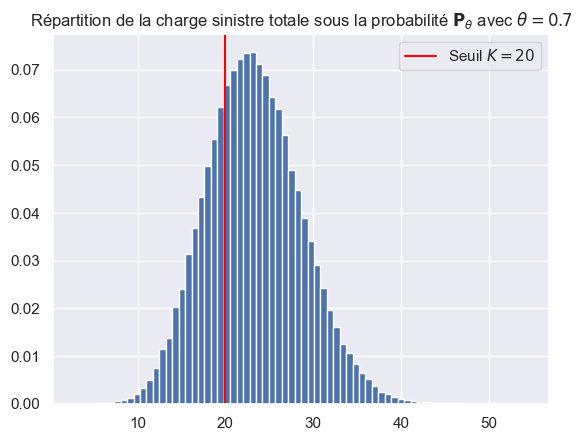

In [19]:
theta = 0.7
sample_S = simu_S_tilde(int(1e5), mu, sigma, lambd, theta=theta)
K = 20

fig, ax = plt.subplots()
ax.hist(sample_S, bins=70, density=True)
ax.axvline(K, color='red', label=fr'Seuil $K={K}$')
ax.set_title(fr"Répartition de la charge sinistre totale sous la probabilité $\mathbf{{P}}_\theta$ avec $\theta = {theta}$")
ax.legend()
plt.show()

### Question: Monte Carlo sous $\mathbf{P}_\theta$

Comparer pour différentes valeurs de $K$, avec $\theta = 0.7$, l'estimateur de Monte Carlo basé sur la représentation 
\begin{equation*}
    \mathbf{P}\biggl[ \sum_{i=1}^N X_i > K \biggr] 
    = \mathbf{E}\biggl[\mathbf{1}_{\sum_{i=1}^{\tilde N} X_i > K } 
    \bigl(\frac{\lambda}{\tilde \lambda} \bigr)^{\tilde N} 
    \exp(\tilde \lambda - \lambda)
    \biggr] \quad \text{avec $\tilde N \sim \mathcal{P}(\tilde \lambda)$}.
\end{equation*}
Pour $K = 22$ le ratio de variance est de l'ordre de 16-17.

Que se passe-t-il si le paramètre $\theta$ est mal choisi? (prendre par exemple $\theta = 1.2$ puis $\theta = 1.5$, et $\theta = -0.1$...)

In [20]:
# on modifie un peu la fonction précédente car on a besoin de N_tilde !
def simu_sous_P_tilde(size, mu, sigma, lambd, theta): 
    sample_N_tilde = rng.poisson(size=size, lam=lambd * np.exp(theta))
    sample_sum = np.empty(size)
    for k, Nk in enumerate(sample_N_tilde):
        sample_sum[k] = np.sum(rng.lognormal(size=Nk, mean=mu, sigma = sigma))
    return sample_sum, sample_N_tilde

In [21]:
from math import log

In [130]:
# on modifie un peu la fonction précédente car on a besoin de N_tilde !
def simu_sous_P_tilde(size, mu, sigma, lambd, theta): 
    #sample_N = np.full((size,), fill_value=15)
    sample_N = rng.poisson(size=size, lam=lambd)
    sample_sum = np.empty(size)
    sample_correction = np.empty(size)
    for k, Nk in enumerate(sample_N):
        if Nk > 0: # and Nk < 15:
            theta = 8*(1./(Nk**(2.))) #(1/sigma)*(0.8*log(20)-np.sqrt(log(Nk))-mu-0.5*sigma**2)
            sample_Gi = theta + rng.standard_normal(size=Nk)
            sample_sum[k] = np.sum(np.exp(mu + sigma*sample_Gi))
            sample_correction[k] = (np.exp(-np.sum(theta*sample_Gi) + Nk*0.5*theta**2)) #**(1/Nk)
        #else: 
        #    sample_Gi = rng.standard_normal(size=Nk)
        #    sample_sum[k] = np.sum(np.exp(mu + sigma*sample_Gi))
            
    return sample_sum, sample_correction

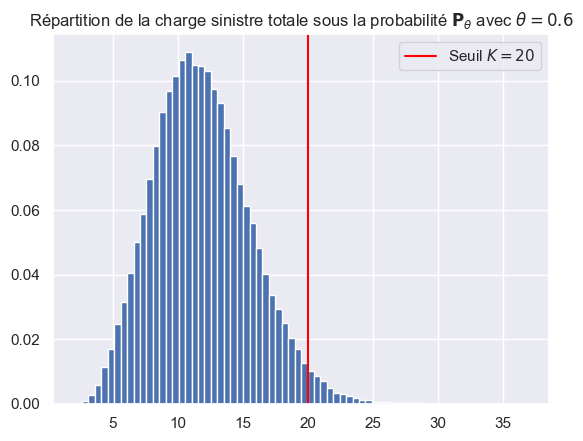

In [131]:
theta = 0.6
sample_S,_ = simu_sous_P_tilde(int(1e5), mu, sigma, lambd, theta=theta)
K = 20

fig, ax = plt.subplots()
ax.hist(sample_S, bins=70, density=True)
ax.axvline(K, color='red', label=fr'Seuil $K={K}$')
ax.set_title(fr"Répartition de la charge sinistre totale sous la probabilité $\mathbf{{P}}_\theta$ avec $\theta = {theta}$")
ax.legend()
plt.show()

In [132]:
Ks = np.arange(20,30)
theta = 0.6

#lambd_tilde = lambd * np.exp(theta)
sample_sum, sample_correction = simu_sous_P_tilde(int(1e6), mu, sigma, lambd, theta)
result = []
for K in Ks:
    sample = (sample_sum > K) * sample_correction #(lambd / lambd_tilde)**sample_N_tilde * np.exp(lambd_tilde - lambd)
    result.append(monte_carlo(sample))
    
import pandas as pd
res_df_is = pd.DataFrame(result, 
                         columns=["mean", "var", "lower", "upper"], 
                         index=Ks)
res_df_is

/var/folders/z7/f1cycb2x0wvfx05bszkps2l80000gn/T/ipykernel_75719/4052842068.py:8: RuntimeWarning: invalid value encountered in multiply
  sample = (sample_sum > K) * sample_correction #(lambd / lambd_tilde)**sample_N_tilde * np.exp(lambd_tilde - lambd)


mean  var  lower  upper
20   NaN  NaN    NaN    NaN
21   NaN  NaN    NaN    NaN
22   NaN  NaN    NaN    NaN
23   NaN  NaN    NaN    NaN
24   NaN  NaN    NaN    NaN
25   NaN  NaN    NaN    NaN
26   NaN  NaN    NaN    NaN
27   NaN  NaN    NaN    NaN
28   NaN  NaN    NaN    NaN
29   NaN  NaN    NaN    NaN

In [189]:
res_df

mean       var     lower     upper
20  0.02060  0.020177  0.018631  0.022569
21  0.01180  0.011661  0.010303  0.013297
22  0.00655  0.006507  0.005432  0.007668
23  0.00375  0.003736  0.002903  0.004597
24  0.00225  0.002245  0.001593  0.002907
25  0.00130  0.001298  0.000801  0.001799

In [ ]:
theta = 0.0


In [160]:
monte_carlo(sample_correction)

(1.0, 0.0, 1.0, 1.0)

In [150]:
sample_correction

array([0.1647477 , 0.33852456, 0.20365708, ..., 0.71131447, 0.2002401 ,
       0.16950798])

In [55]:
?np.full

Signature: np.full(shape, fill_value, dtype=None, order='C', *, like=None)
Docstring:
Return a new array of given shape and type, filled with `fill_value`.

Parameters
----------
shape : int or sequence of ints
    Shape of the new array, e.g., ``(2, 3)`` or ``2``.
fill_value : scalar or array_like
    Fill value.
dtype : data-type, optional
    The desired data-type for the array  The default, None, means
     ``np.array(fill_value).dtype``.
order : {'C', 'F'}, optional
    Whether to store multidimensional data in C- or Fortran-contiguous
    (row- or column-wise) order in memory.
like : array_like, optional
    Reference object to allow the creation of arrays which are not
    NumPy arrays. If an array-like passed in as ``like`` supports
    the ``__array_function__`` protocol, the result will be defined
    by it. In this case, it ensures the creation of an array object
    compatible with that passed in via this argument.

    .. versionadded:: 1.20.0

Returns
-------
out : ndarra

In [110]:
monte_carlo(1./sample_correction)

/var/folders/z7/f1cycb2x0wvfx05bszkps2l80000gn/T/ipykernel_48366/2518965363.py:1: RuntimeWarning: divide by zero encountered in divide
  monte_carlo(1./sample_correction)
/Users/lemaire/.venv/lib/python3.11/site-packages/numpy/core/_methods.py:173: RuntimeWarning: invalid value encountered in subtract
  x = asanyarray(arr - arrmean)


(inf, nan, nan, nan)

In [169]:
Ks = np.arange(20,26)
theta = 0.0

#lambd_tilde = lambd * np.exp(theta)
sample_sum, sample_correction = simu_sous_P_tilde(int(2e6), mu, sigma, lambd, theta)
result = []
for K in Ks:
    sample = (sample_sum > K) * sample_correction #(lambd / lambd_tilde)**sample_N_tilde * np.exp(lambd_tilde - lambd)
    result.append(monte_carlo(sample))
    
import pandas as pd
res_df_is = pd.DataFrame(result, 
                         columns=["mean", "var", "lower", "upper"], 
                         index=Ks)
res_df_is

mean       var         lower     upper
20  0.033135  0.032038  3.288744e-02  0.033384
21  0.007144  0.007093  7.027775e-03  0.007261
22  0.001236  0.001234  1.187306e-03  0.001285
23  0.000185  0.000184  1.656769e-04  0.000203
24  0.000020  0.000020  1.380211e-05  0.000026
25  0.000003  0.000002  3.086958e-07  0.000005

In [48]:
res_df

mean       var     lower     upper
20  0.02060  0.020177  0.018631  0.022569
21  0.01180  0.011661  0.010303  0.013297
22  0.00655  0.006507  0.005432  0.007668
23  0.00375  0.003736  0.002903  0.004597
24  0.00225  0.002245  0.001593  0.002907
25  0.00130  0.001298  0.000801  0.001799

In [25]:
res_df["var"] / res_df_is["var"]

NameError: name 'res_df_is' is not defined

## Calcul de sensibilités 

On utilisera la notation $S^{(\lambda)}$ pour indiquer la dépendance de variable aléatoire $S = \sum_{i=1}^{N} X_i$ en le paramètre $\lambda > 0$ (paramètre de la loi de Poisson sous-jacente). On s'intéresse à la sensibilité de la probabilité $p$ en fonction de lambda c'est à dire 
\begin{equation*}
    \frac{\partial}{\partial \lambda} p(\lambda) = \frac{\partial}{\partial \lambda} \mathbf{P} \bigl[ S^{\lambda} > K \bigl]
\end{equation*}

### Différences finies
Implémenter l'estimateur Monte Carlo basé sur les différences finies d'ordre 2 
\begin{equation*}
    \frac{\partial}{\partial \lambda} p(\lambda) = \frac{p(\lambda + h) - p(\lambda- h)}{2h} + \mathcal{O}(h^2)
\end{equation*}
Comme vu en cours, il y a plusieurs façon d'implémenter l'estimateur Monte Carlo dans ce cadre biaisé. 

Le **premier estimateur** naïf $J^{(1)}_{n,h}(\lambda)$ est basé sur des réalisations indépendantes de $S^{(\lambda+h)}$ et $S^{(\lambda-h)}$ et n'est pas efficace: la variance explose lorsque $h$ tend vers 0. Ainsi on pose
\begin{equation*}
    J^{(1)}_{n, h}(\lambda) = \frac{1}{2 h n} \bigl( \sum_{k = 1}^n \mathbf{1}_{\{S^{(\lambda+h)}_k > K\}} - \sum_{k = 1}^n  \mathbf{1}_{\{\tilde S^{(\lambda-h)}_k > K\}} \bigr),
\end{equation*}
où $(S^{(\lambda+h)}_k)_{k \ge 1}$ et $(\tilde S^{(\lambda-h)}_k)_{k \ge 1}$ sont des suites indépendantes de variables aléatoires _i.i.d._.

Le **deuxième estimateur** $J^{(2)}_{n,h}(\lambda)$ utilise des réalisations fortements corrélées de la loi de Poisson au sens suivant: on utilise la même réalisation uniforme $U$ pour constuire deux réalisations $N^{(\lambda+h)}$ et $N^{(\lambda-h)}$ en utilisant la méthode de l'inverse de la fonction de répartition. Dans ce deuxième estimateur, les lois log-normales sont indépendantes. On a donc
\begin{equation*}
    J^{(2)}_{n, h}(\lambda) = \frac{1}{2 h n} \sum_{k = 1}^n \bigl(\mathbf{1}_{\{S^{(\lambda+h)}_k > K\}} - \mathbf{1}_{\{\bar S^{(\lambda-h)}_k > K\}} \bigr),
\end{equation*}
où pour $k \ge 1$, $S^{(\lambda+h)}_k = \sum_{i = 1}^{G(\lambda+h, U_k)} X_{i,k}$ et $\bar S^{(\lambda-h)}_k = \sum_{i = 1}^{G(\lambda-h, U_k)} \bar X_{i,k}$ avec $G(\lambda, u)$ l'inverse généralisée de la loi de Poisson de paramètre $\lambda$, $(U_k)_{k \ge 1}$ suite _i.i.d._ uniforme sur $[0,1]$ indépendante de $(X_{i,k})_{i\ge1, k\ge 1}$ et $(\bar X_{i,k})_{i\ge1, k\ge 1}$ deux suites (doublement indicées) _i.i.d._ de loi log-normale (de paramètres $\mu$ et $\sigma$ inchangés).

Un **troisième estimateur** $J^{(3)}_{n,h}(\lambda)$ utilise des réalisations fortements corrélées de la loi de Poisson et des variables aléatoires log-normales communes. 
\begin{equation*}
    J^{(3)}_{n, h}(\lambda) = \frac{1}{2 h n} \sum_{k = 1}^n \bigl(\mathbf{1}_{\{S^{(\lambda+h)}_k > K\}} - \mathbf{1}_{\{S^{(\lambda-h)}_k > K\}} \bigr),
\end{equation*}
où pour $k \ge 1$, $S^{(\lambda+h)}_k = \sum_{i = 1}^{G(\lambda+h, U_k)} X_{i,k}$ et $S^{(\lambda-h)}_k = \sum_{i = 1}^{G(\lambda-h, U_k)} X_{i,k}$ avec $G(\lambda, u)$ l'inverse généralisée de la loi de Poisson de paramètre $\lambda$, $(U_k)_{k \ge 1}$ suite _i.i.d._ uniforme sur $[0,1]$ indépendante de $(X_{i,k})_{i\ge1, k\ge 1}$ une suite (doublement indicée) _i.i.d._ de loi log-normale.

### Question: plusieurs estimateurs des différences finies 

On fixe les paramètres $\lambda = 10$, $\mu = 0.1$, $\sigma = 0.3$ et $K = 20$.
Programmer ces 3 estimateurs pour différentes valeurs de $h$ (par exemple, $h=1$, 0.5, 0.1 et 0.01), et donner le résultat des estimateurs Monte Carlo avec $n = 50\,000$.

Que se passe-t-il lorsque $h$ tend vers 0? Comparez le comportement pour ces 3 estimateurs. Il est très important de bien interpréter ces tableaux de résultats et de conclure qu'il faut utiliser l'estimateur $J^{(3)}_{n, h}(\lambda)$ et en aucun cas l'estimateur $J^{(1)}_{n,h}(\lambda)$.

_Remarque_: on considère ici uniquement l'étude de l'erreur statistique dûe à la méthode de Monte Carlo. On ne considère pas l'erreur de biais qui décroît lorsque $h$ tend vers 0 et qui est peut-être non négligeable pour $h = 1$. Les IC construits ici sont biaisés et on ne peut pas affirmer que la vraie valeur est dans l'IC à 95% (au moins pour les grandes valeurs de $h$). 

In [23]:
lambd, mu, sigma = 10, 0.1, 0.3
K = 20

In [24]:
def J1(n, h): 
    sample_Sph = simu_S(n, mu, sigma, lambd+h)
    sample_Smh = simu_S(n, mu, sigma, lambd-h)
    xph = (sample_Sph > K).astype(int)
    xmh = (sample_Smh > K).astype(int)
    return monte_carlo((xph - xmh)/(2*h))

In [25]:
# on crée une fonction pour ne pas répéter ces lignes de code
def result_estimator(J, n=50000, hs=[1, 0.5, 0.1, 0.01]):
    result = [ J(n, h) for h in hs ]
    df = pd.DataFrame(result, 
                      columns=['mean', 'var', 'lower', 'upper'], 
                      index=hs)
    return df

In [26]:
result_estimator(J1)

mean         var     lower     upper
1.00  0.01711    0.012552  0.016128  0.018092
0.50  0.01520    0.044250  0.013356  0.017044
0.10  0.01650    1.042249  0.007552  0.025448
0.01 -0.03000  105.401208 -0.119988  0.059988

In [27]:
def J2(n, h): 
    sample_U = rng.random(size=n)
    sample_Nph = stats.poisson(mu = lambd+h).ppf(sample_U)
    sample_Nmh = stats.poisson(mu = lambd-h).ppf(sample_U)
    sample_Sph = np.empty(n)
    sample_Smh = np.empty(n)
    for k, (Nph, Nmh) in enumerate(zip(sample_Nph, sample_Nmh)):
        sample_Sph[k] = np.sum(rng.lognormal(size=int(Nph), mean=mu, sigma = sigma))
        sample_Smh[k] = np.sum(rng.lognormal(size=int(Nmh), mean=mu, sigma = sigma))
    xph = (sample_Sph > K).astype(int)
    xmh = (sample_Smh > K).astype(int)
    return monte_carlo((xph - xmh)/(2*h))

In [28]:
result_estimator(J2)

mean        var     lower     upper
1.00  0.01666   0.008433  0.015855  0.017465
0.50  0.01656   0.023406  0.015219  0.017901
0.10  0.01710   0.473217  0.011070  0.023130
0.01  0.05700  44.047632 -0.001173  0.115173

In [29]:
def J3(n, h): 
    sample_U = rng.random(size=n)
    sample_Nph = stats.poisson(mu = lambd+h).ppf(sample_U).astype(int)
    sample_Nmh = stats.poisson(mu = lambd-h).ppf(sample_U).astype(int)
    sample_Sph = np.empty(n)
    sample_Smh = np.empty(n)
    for k, (Nph, Nmh) in enumerate(zip(sample_Nph, sample_Nmh)):
        max_N = max(Nph, Nmh)
        sample_X = rng.lognormal(size=max_N, mean=mu, sigma = sigma)
        sample_Sph[k] = np.sum(sample_X[:Nph])
        sample_Smh[k] = np.sum(sample_X[:Nmh])
    xph = (sample_Sph > K).astype(int)
    xmh = (sample_Smh > K).astype(int)
    return monte_carlo((xph - xmh)/(2*h))

In [30]:
result_estimator(J3)

mean       var     lower     upper
1.00  0.01747  0.008430  0.016665  0.018275
0.50  0.01672  0.016441  0.015596  0.017844
0.10  0.01730  0.086202  0.014727  0.019873
0.01  0.02300  1.149494  0.013602  0.032398